# 数据探索性分析与数据预处理
## 1. 数据可视化和摘要
### 数据摘要

* 读入数据，并识别缺失值

In [1]:
import pandas as pd
import numpy as np
import json
import os
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy.stats as spss
import seaborn as sns

In [2]:
data_path = "data"
file_list = os.listdir(data_path + os.sep)

dataset = None
date_columns = ['Create Time', 'Closed Time']

for file_path in file_list:
    if not isinstance(dataset, pd.DataFrame):
        dataset = pd.read_csv(data_path + os.sep + file_path, parse_dates=date_columns)

    else:
        temp_dataset = pd.read_csv(data_path + os.sep + file_path, parse_dates=date_columns)
        temp_dataset.rename({'Location 1': 'Location', 'Location ': 'Location'}, axis=1, inplace=True)
        dataset = pd.concat([dataset, temp_dataset], ignore_index=True, sort=False)


In [172]:
pattern = re.compile('"address":"(.*?)"')

def f(x):
    result = re.search(pattern, x)
    if not result:
        if not x:
            return np.nan
        else:
            return x.strip()
    else:
        return result[1].strip()

dataset['Location'] = dataset['Location'].apply(f)  # 清理数据，部分数据集的Location属性以dict形式进行存储，且存储方式不符合json的标准化，所以使用正则表达式进行提纯
dataset.name = "Origin Dataset"

* 标称属性的统计

In [217]:
nominal_attributes = ['Location', 'Area Id', 'Beat', 'Priority', 'Incident Type Id', 'Incident Type Description', 'Event Number']

for attribute in nominal_attributes:
    print(dataset[attribute].value_counts().head())

INTERNATIONAL BLVD       20735
MACARTHUR BLVD           17196
BROADWAY                 12214
AV&INTERNATIONAL BLVD    11407
FOOTHILL BLVD             9669
Name: Location, dtype: int64
1.0    290452
2.0    236700
P3     129054
P1     114560
P2      53033
Name: Area Id, dtype: int64
04X    43626
08X    38097
30Y    30880
26Y    30377
30X    29881
Name: Beat, dtype: int64
2.0    814818
1.0    231542
0.0        24
Name: Priority, dtype: int64
933R     98497
SECCK    70965
415      66720
911H     54935
10851    47958
Name: Incident Type Id, dtype: int64
ALARM-RINGER            98497
SECURITY CHECK          70965
911 HANG-UP             54935
STOLEN VEHICLE          47958
DISTURBING THE PEACE    38257
Name: Incident Type Description, dtype: int64
LOP111209000028    1
LOP131008000605    1
LOP150402000474    1
LOP120206000697    1
LOP130617000531    1
Name: Event Number, dtype: int64


> 以上是对所有标称属性的统计，考虑到版面的问题，只打印了统计频数的前五个最大值

* 数值属性
> 本数据集中不存在数值属性，所以无法统计

### 数据可视化

* 本数据中不存在数值属性，所以仅对部分标称属性的统计值绘制条形图显示

In [218]:
for attribute in nominal_attributes:
    print(dataset[attribute].value_counts().shape)  # 由统计值可知，仅'Area Id', 'Priority'这两个属性有较好的可视化效果，其它的条类过多，不适合条形图显示

(130603,)
(13,)
(58,)
(3,)
(288,)
(288,)
(1046384,)


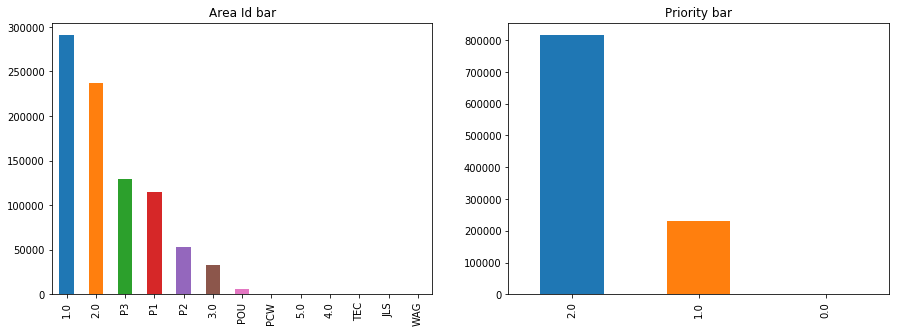

In [228]:
fig = plt.figure()
fig.set_size_inches(15, 5)
attributes = ['Area Id', 'Priority']

for index, attribute in enumerate(attributes):
    ax = fig.add_subplot(1, 2, index + 1)
    dataset[attribute].value_counts().plot(kind='bar', ax=ax, title=attribute+' bar')

## 2. 缺失数据的处理

In [246]:
dataset.isna().sum()  #缺失值统计

Agency                            4
Create Time                       4
Location                        300
Area Id                      182365
Beat                           5805
Priority                          4
Incident Type Id                  4
Incident Type Description       392
Event Number                      4
Closed Time                      29
dtype: int64

In [242]:
def show(attribute):
    return dataset[dataset[attribute].isna()]

In [280]:
for attribute in nominal_attributes:
    result = show(attribute)
    print(f"Nan of {attribute} {len(dataset[dataset[attribute].isna()])}: ")
    for compare_attribute in nominal_attributes:
        temp = result[compare_attribute].value_counts().head() / len(result) * 100
        print(f"    {compare_attribute}({dataset[compare_attribute].value_counts().shape}):")
        for name, item in temp.items():
            print(f"        {name}: {item}")

Nan of Location 300: 
    Location((130602,)):
    Area Id((13,)):
        1.0: 24.666666666666668
        2.0: 24.333333333333336
        P1: 11.0
        P3: 10.333333333333334
        PCW: 6.0
    Beat((58,)):
        33X: 1.0
        31X: 0.6666666666666667
        24X: 0.6666666666666667
        21Y: 0.6666666666666667
        32Y: 0.6666666666666667
    Priority((3,)):
        2.0: 73.0
        1.0: 25.666666666666664
    Incident Type Id((288,)):
        SECCK: 12.333333333333334
        20002: 7.000000000000001
        900: 6.666666666666667
        HAZ: 5.333333333333334
        901A: 5.0
    Incident Type Description((288,)):
        SECURITY CHECK: 12.333333333333334
        HIT & RUN (PROPERTY: 7.000000000000001
        MISCELLANEOUS/UNKNOW: 6.666666666666667
        HAZARDOUS SITUATION/: 5.333333333333334
        VEHICLE COLLISION-PE: 5.0
    Event Number((1046384,)):
        LOP130625000750: 0.33333333333333337
        LOP130403000309: 0.33333333333333337
        LOP15041

> 以上是对所有缺失值与其它属性关系的结果打印，可以看到，Location的缺失和案件发生的地点，优先级及事件类型呈明显的聚集特性，从上述几类属性都可以发现，
> 数据的缺失主要来自于优先级为2的部分，在各类属性的缺失值中都占到了60%以上，可以认为是案件的优先级对数据本身有影响。且incident id为JGP的案件，对应
> 案件描述均为空，且具有地域聚集性，多出现在FAIRMONT DR，案件结案时间多为当天，可以认为案件严重性较小，所以缺少具体描述。

* 剔除缺失值

In [137]:
clear_dataset_1 = dataset.dropna()

In [178]:
clear_dataset_1.isna().sum()

Agency                       0
Create Time                  0
Location                     0
Area Id                      0
Beat                         0
Priority                     0
Incident Type Id             0
Incident Type Description    0
Event Number                 0
Closed Time                  0
dtype: int64

* 通最高频率值来填补缺失值

In [138]:
def fill_with_mode(series):
    mode = series.dropna().mode()[0]
    
    print(f"Mode of column {series.name} is: {mode}")
    return series.fillna(mode)

In [174]:
clear_dataset_2 = dataset.apply(fill_with_mode)
clear_dataset_2.isna().sum()
clear_dataset_2.name = "Filled with mode dataset"

Mode of column Agency is: OP
Mode of column Agency is: OP
Mode of column Create Time is: 2013-01-29 09:16:31
Mode of column Location is: INTERNATIONAL BLVD
Mode of column Area Id is: 1.0
Mode of column Beat is: 04X
Mode of column Priority is: 2.0
Mode of column Incident Type Id is: 933R
Mode of column Incident Type Description is: ALARM-RINGER
Mode of column Event Number is: LOP110101000001
Mode of column Closed Time is: 2013-02-12 22:52:01


* 通过数据对象之间的相似性来填补缺失值
> 从缺失值数量来看，Area Id的缺失最多，所以下面使用决策树对Area Id进行填充，由于数据集中的属性都是标称属性，所以使用Onehot进行编码，便于决策树进行训练

In [105]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

clf = DecisionTreeClassifier()
train_attributes = ['Beat', 'Incident Type Id', 'Priority', 'Location']  # 使用这四个属性对Area Id进行预测
predict_attribute = ['Area Id', ]

train_dataset_onehot = OneHotEncoder(categories='auto')
train_predict_onehot = OneHotEncoder(categories='auto')

train_dataset_onehot.fit(dataset.astype(str)[train_attributes])
train_predict_onehot.fit(dataset[predict_attribute].dropna().astype(str))

sample_dataset = dataset.dropna().sample(5000).astype(str)  # 随机采样4500个样本进行测试
td = train_dataset_onehot.transform(sample_dataset[train_attributes]).todense()
tp = train_predict_onehot.transform(sample_dataset[predict_attribute]).todense()

scores = cross_val_score(clf, td, tp, cv=5)  # 交叉检验，分为5折
print(f"scores of DecisionTreeClassifier is {scores.mean()}")

scores of DecisionTreeClassifier is 0.4953333333333333


> 从测试结果来看，分类的准确率能达到50%作为，考虑到Area Id有13个类别，这样的分类准确度基本达到了要求。
> 这里的缺陷在于没有对案件的时间长度进行计算统计，如果将这个特征加入，效果可能还会增加，后期对大作业进行数据分析时，再加以考虑。

In [106]:
clf.fit(td,tp)  # 训练决策树

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [158]:
predict_index = dataset[dataset['Area Id'].isna()].notna().index
clear_dataset_3 = dataset.copy().astype({'Area Id': str})

In [159]:
clear_dataset_3.loc[predict_index, ['Area Id', ]] = train_predict_onehot.inverse_transform(clf.predict(train_dataset_onehot.transform(dataset.iloc[predict_index][train_attributes].astype(str))))

In [176]:
clear_dataset_3.isna().sum()

Agency                          4
Create Time                     4
Location                        0
Area Id                         0
Beat                         5805
Priority                        4
Incident Type Id                4
Incident Type Description     392
Event Number                    4
Closed Time                    29
dtype: int64

> 从上述结果可以看到，所有空缺的Area Id被填充，其它属性填充方法类似，不一一展示。

### 可视化对比新旧数据集

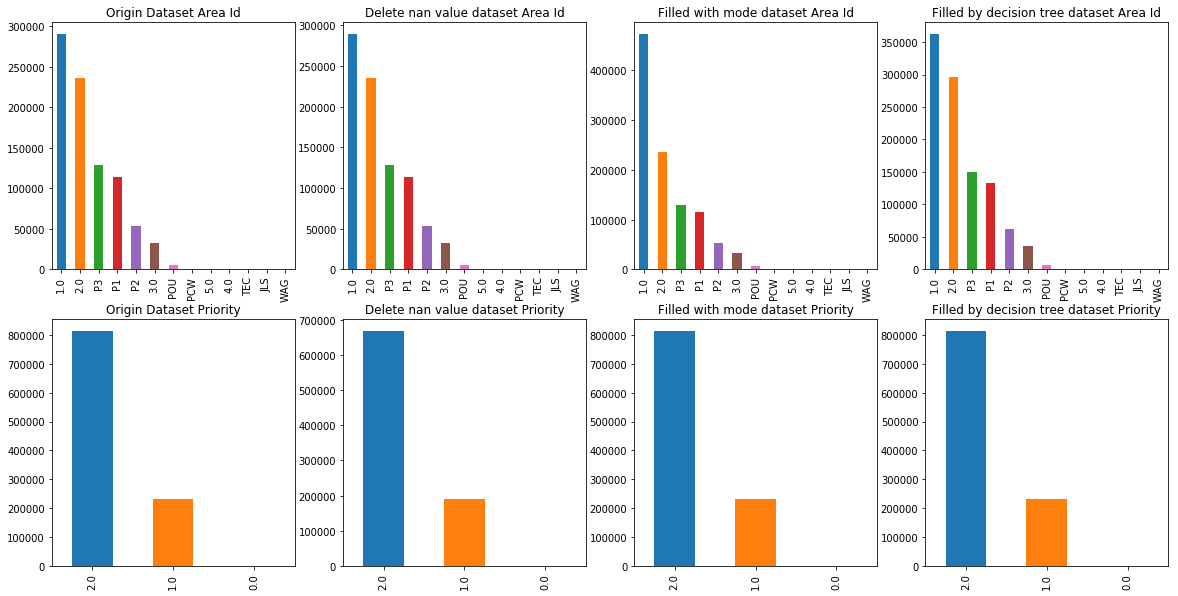

In [181]:
fig = plt.figure()
fig.set_size_inches(20, 10)
attributes = ['Area Id', 'Priority']
datasets = [dataset, clear_dataset_1, clear_dataset_2, clear_dataset_3]

for row, attribute in enumerate(attributes):
    for col, data in enumerate(datasets):
        ax = fig.add_subplot(2, 4, row * 4 + col + 1)
        data[attribute].value_counts().plot(kind='bar', ax=ax, title=data.name + " " + attribute)

> 以上是对处理以后四个数据集Area Id及Priority部分的可视化处理，可以看到，直接删除缺失值和通过决策树预测分类填充得到的数据，在Area Id属性上更符合原始数据分布，而在Priority属性上，则通过众数填充和决策树填充的数据集更接近原始数据分布，
> 比较后发现，对于数据缺失值的处理，通过数据对象间的相似性得到的填充值更加符合原始分布。